In [551]:
import numpy as np
import random
import scipy.optimize as sco
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
from IPython.display import Image
import utils as ut

import sys
sys.path.append(r"C:\Users\jeope\AppData\Roaming\Microsoft\Windows\Start Menu\Programs\MiKTeX\MiKTeX Console.lnk")

from seaborn import color_palette, set_palette
from matplotlib import rc, cm

plt.style.use('seaborn-white')
set_palette("deep")

rc('font', **{'family': 'serif', 'serif': ['Palatino']})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{underscore}')

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

C:\Users\jeope\AppData\Local\Temp\ipykernel_25772\2462426440.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [2]:
def efficient_frontier(X, risk, nb_T, s0, v,sigma,benchmark='IS', tau=1.0, gamma=1.0, eta=1.0, eps=1.0, plot='True'):
    """
    Returns the optimal expectation and variance as well as the trading trajectory.
    It plots the trading trajectory.
    
    --------------------------------------------------------------------------
    Parameters:

    X, integer - Number of shares to be liquidated
    risk, float - Risk aversion coefficient
    nb_T, integer - Number of trading periods
    gamma, float - Parameter of the permanent market impact
    tau, float - Trading frequency
    eta, float - Parameter of the temporary market impact
    eps, float - Fixed cost of selling in the temporary market impact
        
    
    """
    V = np.sum(v)
    
    ########################################################################################################
    ############################################ MARKET IMPACT #############################################
    ########################################################################################################
    
    def g(x, gamma=2.5*10**(-7), alpha=1):
        """
        Permanent market impact
        """
        return gamma * x ** alpha

    def h(x, eta=2.5*10**(-6), epsilon=0.0625, beta=1):
        """
        Temporary market impact
        """
        return epsilon*np.sign(x) + eta*(x/tau)**beta

    ########################################################################################################
    ################################################## IS ##################################################
    ########################################################################################################
    
    def expectation_IS(n):
        """
        Returns the expectation of implementation shortfall.
        
        --------------------------------------------------------------------------
        Parameters:

        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        
        """
        
        exp = 0.5*gamma*X**2 + eps*np.sum(n) + (eta - 0.5*gamma)/tau * np.sum(n**2)
        return exp

    def variance_IS(n):
        """
        Returns the variance of implementation shortfall.
        
        --------------------------------------------------------------------------
        Parameters:

        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        sigma, array - Volatility of the stock
        
        """
        
        var = 0
        t = - 1
        while t < len(n) - 1:
            t = t + 1
            temp = (X - np.sum(n[0:t])) ** 2
            var = var + temp * sigma[t] **2
        var = tau * var
        return var

    def objective_IS(n):
        """
        Returns the objective function for implementation shortfall.
        """
        
        obj = expectation_IS(n) + risk * variance_IS(n)
        return obj
    
    ########################################################################################################
    ############################################ OPTIMIZATION ##############################################
    ########################################################################################################
    
    def optimization(benchmark):
        """
        Optimal execution with optimization for implementation shortfall.
        
        Returns the optimal trading trajectory.
        """
        
        x0  = np.ones((nb_T,1)) * X / nb_T
        bnds = tuple((0.0, X) for x in range(len(x0)))
        cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})
        
        if benchmark == "IS":
            opt = sco.minimize(objective_IS, x0, method='SLSQP', bounds=bnds, constraints=cons) 
            
        elif benchmark == "VWAP":
            opt = sco.minimize(objective_VWAP, x0, method='SLSQP', bounds=bnds, constraints=cons) 
            
        elif benchmark == "TWAP":
            opt = sco.minimize(objective_TWAP, x0, method='SLSQP', bounds=bnds, constraints=cons) 
            
        else:
            raise ValueError("Unknown benchmark: " + str(benchmark))
            
        n = np.array(opt.x)
        return n
    
    def liquidation_history(N_opt, X):
        """
        Prints out the liquidation history of the optimal execution.
        
        --------------------------------------------------------------------------
        Parameters:

        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        
        """
        
        x_k=[X]
        for i in range(len(N_opt)):
            x_k.append(x_k[i] - N_opt[i])
        return x_k

    def plot_liquidation():
        plt.figure(figsize=(7,5))
        plt.plot(hist_opt, color='blue', lw=1.5)
        plt.grid(True)
        plt.xlabel('Time')
        plt.ylabel('Nb. of shares')
        plt.title("Liquidation path for "+benchmark+" and risk aversion of: " +str(risk))
        plt.show()
        
    N_opt = optimization(benchmark)
    hist_opt = liquidation_history(N_opt,X)
    
    if plot=='True':
        plot_liquidation()
    
    if benchmark == 'IS':
        ex=expectation_IS(N_opt)
        va=variance_IS(N_opt)
    elif benchmark == 'VWAP':
        ex=expectation_VWAP(N_opt)
        va=variance_VWAP(N_opt)
    elif benchmark == 'TWAP':
        ex=expectation_TWAP(N_opt)
        va=variance_TWAP(N_opt)
    else:
        raise ValueError("Unknown benchmark.")
        
    res = hist_opt, ex,va
    
    return res

In [3]:
# Parameters definition
_tau = 1
_gamma = 2.5*10**(-7)
_eta = 2.5*10**(-6)
_eps = 0.0625
trading_time = 5

# Variables definition
_s0 = 50      # spot
_X = 1e6      # Initial inventory
_nb_T = 5    # number of trading periods
_cs = 0.3/np.sqrt(250)     # constant daily volatility
_sigma = [_cs * _s0 for t in range(_nb_T)]

## Price evolution
gauss_mu, gauss_sigma = 0, 1
gauss_s = np.random.normal(gauss_mu, gauss_sigma, trading_time)/100
gauss_innovation = 1+gauss_s
_s0_gauss = 50*np.cumprod(gauss_innovation)
_s0_gauss = np.append(50,_s0_gauss)
_cs_gauss = 0.3/np.sqrt(250)
_sigma_gauss = [_cs_gauss * _s0_gauss]
_sigma_gauss = np.squeeze(_sigma_gauss)

t_s = np.random.standard_t(1, 5)/100
t_innovation = 1+t_s
_s0_t = 50*np.cumprod(t_innovation)
_s0_t = np.append(50,_s0_t)
_cs_t = 0.3/np.sqrt(250)
_sigma_t = [_cs_t * _s0_t]
_sigma_t = np.squeeze(_sigma_t)


C:\Users\jeope\AppData\Local\Temp\ipykernel_25772\2995182892.py:110: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  opt = sco.minimize(objective_IS, x0, method='SLSQP', bounds=bnds, constraints=cons)


[1000000.0, 12552.286584085901, 2775.831640001401, 285.71557218556336, 100.65192324599181, -5.5862869885459077e-11]
[1000000.0, 103421.54127775517, 8885.00820093388, 1751.9014340160757, 384.88843988294207, 4.7975845518521965e-11]
[1000000.0, 441387.7636324399, 172442.3185020365, 64979.86814881531, 43304.47803675114, 5.820766091346741e-11]
[1000000.0, 723208.1648478233, 498827.07640801545, 312674.35581681854, 149703.64805871257, 1.1641532182693481e-10]
[1000000.0, 791103.1475023527, 587660.1043054895, 389032.8164747248, 193667.05579024722, -8.731149137020111e-11]
[1000000.0, 800000.0, 600000.0, 400000.0, 200000.0, 0.0]
[1000000.0, 800000.0, 600000.0, 400000.0, 200000.0, 0.0]


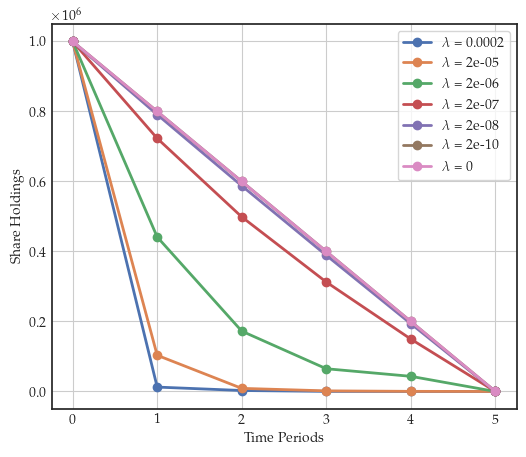

[1000000.0, 12552.286584085901, 2775.831640001401, 285.71557218556336, 100.65192324599181, -5.5862869885459077e-11]
[1000000.0, 103421.54127775517, 8885.00820093388, 1751.9014340160757, 384.88843988294207, 4.7975845518521965e-11]
[1000000.0, 441387.7636324399, 172442.3185020365, 64979.86814881531, 43304.47803675114, 5.820766091346741e-11]
[1000000.0, 723208.1648478233, 498827.07640801545, 312674.35581681854, 149703.64805871257, 1.1641532182693481e-10]
[1000000.0, 791103.1475023527, 587660.1043054895, 389032.8164747248, 193667.05579024722, -8.731149137020111e-11]
[1000000.0, 800000.0, 600000.0, 400000.0, 200000.0, 0.0]
[1000000.0, 800000.0, 600000.0, 400000.0, 200000.0, 0.0]


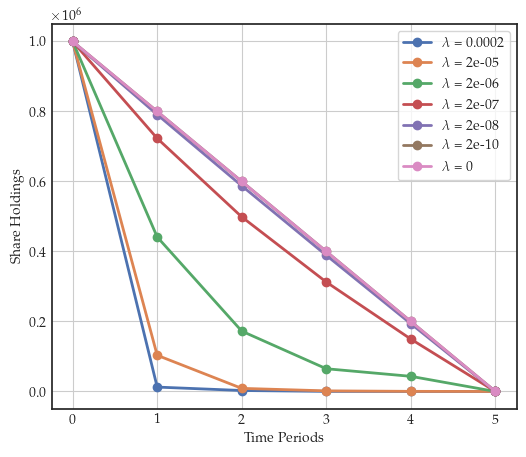

In [4]:
def comparison_ef(risks, X, nb_T, s0, v,sigma,benchmark='IS', tau=1.0, gamma=1.0, eta=1.0, eps=1.0):
    
    """
    Plots the optimal trading trajectories for a list of risk aversion coefficients
    """
    
    N_opts = []
    diff_traj = []

    for r in risks:
        temp = efficient_frontier(X, r, nb_T, s0, v,sigma,benchmark, tau, gamma, eta, eps,False)

        N_opts.append(temp[0])
        diff_traj.append(np.diff(temp[0])*-1)
    print(N_opts[0])
    print(N_opts[1])
    print(N_opts[2])
    print(N_opts[3])
    print(N_opts[4])
    print(N_opts[5])
    print(N_opts[6])

    # Plotting
    plt.figure(figsize=(6,5),dpi=100)
    plt.plot(N_opts[0],marker='o', lw=2.0, label=r'$\lambda$ = '+str(risks[0]))
    plt.plot(N_opts[1],marker='o', lw=2.0, label=r'$\lambda$ = '+str(risks[1]))
    plt.plot(N_opts[2], marker='o', lw=2.0, label=r'$\lambda$ = '+str(risks[2]))
    plt.plot(N_opts[3], marker='o', lw=2.0, label=r'$\lambda$ = '+str(risks[3]))
    plt.plot(N_opts[4],marker='o', lw=2.0, label=r'$\lambda$ = '+str(risks[4]))
    plt.plot(N_opts[5], marker='o', lw=2.0, label=r'$\lambda$ = '+str(risks[5]))
    plt.plot(N_opts[6], marker='o', lw=2.0, label=r'$\lambda$ = '+str(risks[6]))

    plt.grid(True)
    #plt.title('Optimal trajectories for '+benchmark)
    plt.xlabel(r'Time Periods')
    plt.ylabel(r'Share Holdings')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.yticks([0*10**5, 2*10**5, 4*10**5, 6*10**5, 8*10**5,10*10**5])
    plt.legend(loc='best',frameon=True)
    plt.savefig('liquidation_IS.png')
    plt.show()
    return diff_traj

risks = [2*10**(-4),2*10**(-5),2*10**(-6),2*10**(-7),2*10**(-8),2*10**(-10),0]
comparison_ef(risks,_X, _nb_T, _s0, 0,_sigma_t,benchmark='IS', tau=1, gamma=_gamma, eta=_eta, eps=0.0625)
t = comparison_ef(risks,_X, _nb_T, _s0, 0,_sigma_t,benchmark='IS', tau=1, gamma=_gamma, eta=_eta, eps=0.0625)

In [5]:
    def expectation_IS(n):
        """
        Returns the expectation of implementation shortfall.
        
        --------------------------------------------------------------------------
        Parameters:

        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        
        """
        
        exp = 0.5*gamma*X**2 + eps*np.sum(n) + (eta - 0.5*gamma)/tau * np.sum(n**2)
        return exp

    def variance_IS(n):
        """
        Returns the variance of implementation shortfall.
        
        --------------------------------------------------------------------------
        Parameters:

        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        sigma, array - Volatility of the stock
        
        """
        
        var = 0
        t = - 1
        while t < len(n) - 1:
            t = t + 1
            temp = (X - np.sum(n[0:t])) ** 2
            var = var + temp * sigma **2
        var = tau * var
        return var

In [933]:
gamma = _gamma
X = _X
eps = _eps
eta = _eta
tau = _tau

t_s = np.random.standard_t(1, 5)/100
t_innovation = 1+t_s
_s0_t = 50*np.cumprod(t_innovation)
_s0_t = np.append(50,_s0_t)
_cs_t = 0.3/np.sqrt(250)
_sigma_t = [_cs_t * _s0_t]
_sigma_t = np.squeeze(_sigma_t)
sigma = _sigma_t
print(_sigma_t)




[0.9486833  0.91854918 0.92298871 0.93104926 0.92784037 0.93474579]


In [958]:
print(round(expectation_IS(t[6])/1e6,5))
print(round(np.mean(variance_IS(t[6]))/1e12,5))

0.6625
1.90561


In [937]:
a = (sigma**2)[1:]
b = tau*t[0]**2
print(a)
print(b)
np.dot(a,b)/1e12

[0.84373259 0.85190816 0.86685272 0.86088775 0.8737497 ]
[9.75052987e+11 9.55790713e+07 6.20067803e+06 3.42485542e+04
 1.01308097e+04]


0.8227708216110194

In [804]:
np.random.seed(10)
iterations = 10
var = []
for i in range(iterations):
    t_s = np.random.standard_t(1, 5)/100
    t_innovation = 1+t_s
    _s0_t = 50*np.cumprod(t_innovation)
    _s0_t = np.append(50,_s0_t)
    _cs_t = 0.3/np.sqrt(250)
    _sigma_t = [_cs_t * _s0_t]
    _sigma_t = np.squeeze(_sigma_t)
    sigma = _sigma_t
    var.append(round(np.mean(variance_IS(t[0]))/1e12,5))

print(var)
print(np.mean(var))

[1.53707, 0.91982, 0.89769, 1.26308, 1.20117, 1.23955, 0.74595, 1.11509, 0.94183, 1.52468]
1.1385929999999997
